In [1]:
import sys
import os
from functools import reduce
from copy import deepcopy

os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
sys.path.append(os.path.join(os.path.dirname(__vsc_ipynb_file__), "../"))

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import dill

import flax.linen as nn
import optax

In [2]:
with open("SIR_experiments/SIR_50_pop.pkl", "rb") as f:
    snl_samples = dill.load(f)

/home/luke/anaconda3/envs/flax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
pmmh_samples = np.loadtxt("SIR_experiments/sir_50_pmmh.csv", delimiter=",", dtype=float)[::20] # Thin the samples

In [19]:
def concat_samples(snl):
    R0_vals = np.concatenate(reduce(lambda x, y: x + [y['R0']], snl['samples'][-5:], []))
    gammai_vals = np.concatenate(reduce(lambda x, y: x + [y['gamma_inv']], snl['samples'][-5:], []))
    return R0_vals, gammai_vals

R0_snl, gamma_inv_snl = concat_samples(snl_samples)
R0_pmmh = pmmh_samples[:,0]
gamma_inv_pmmh = pmmh_samples[:,1]

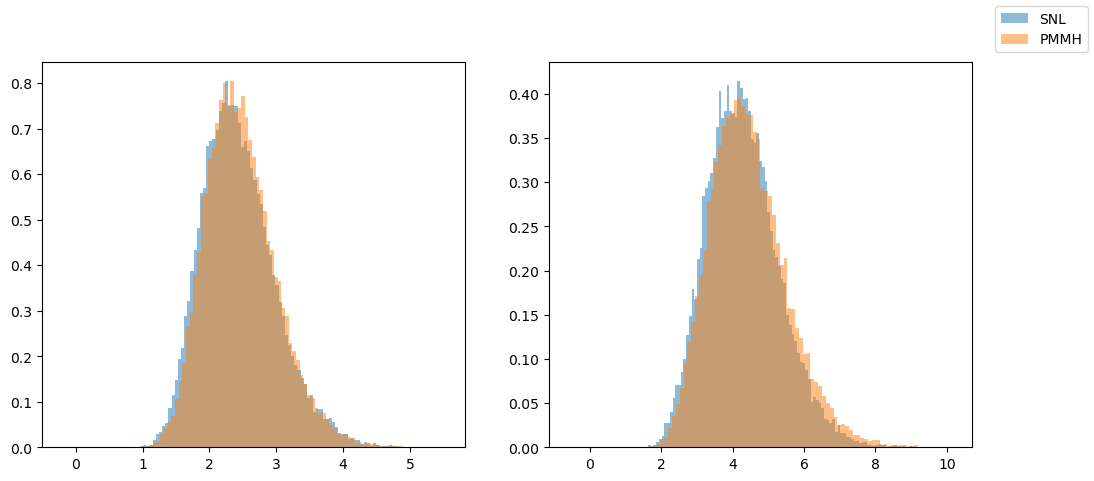

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(R0_snl, bins=100, density=True, alpha=0.5, label="SNL")
ax[0].hist(R0_pmmh, bins=100, density=True, alpha=0.5, label="PMMH")

ax[1].hist(gamma_inv_snl, bins=100, density=True, alpha=0.5)
ax[1].hist(gamma_inv_pmmh, bins=100, density=True, alpha=0.5)
fig.legend()
plt.show()

## Classifier 2 sample t-test

In [21]:
class MLP(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(20)(x))
        return nn.Dense(1)(x)

model = MLP()

def create_params(key):
    # Define MLP model
    dummy_input = jnp.ones((2,))
    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    return params

@jax.jit
def loss(params, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def ce(x, y):
    z = model.apply(params, x)
    lsz = nn.log_sigmoid(z)
    return -y * lsz - (1 - y) * (lsz - z)
  # Vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(ce)(x_batched,y_batched))

def make_dataset(R0_snl, gamma_inv_snl, pmmh_samples, num_test=10_000, val_prop=0.1):

    xsnl = np.stack((R0_snl, gamma_inv_snl)).T
    ysnl = np.zeros(xsnl.shape[0]) # 0 for snl samples

    xpmmh = pmmh_samples
    ypmmh = np.ones(xpmmh.shape[0]) # 1 for pmmh samples

    x = np.concatenate((xsnl, xpmmh), axis=0)
    y = np.concatenate((ysnl, ypmmh), axis=0)

    x = (x - x.mean(axis=0)) / x.std(axis=0)

    perm = np.random.permutation(x.shape[0])
    num_train = int((perm.shape[0] - num_test) * (1 - val_prop))
    num_val = perm.shape[0] - (num_test + num_train)
    train_idx, val_idx, test_idx = perm[:num_train], perm[num_train:(num_train+num_val)], perm[(num_train+num_val):]

    train_x, val_x, test_x = x[train_idx], x[val_idx], x[test_idx]
    train_y, val_y, test_y = y[train_idx], y[val_idx], y[test_idx]
    
    return {"train": (train_x, train_y), "val": (val_x, val_y), "test": (test_x, test_y)}

tx = optax.adam(learning_rate=1e-3)
loss_grad_fn = jax.value_and_grad(loss)

In [22]:
# Not strictly necessary, but stops JAX from tracing for loop during compilation
def make_epoch(tx, batch_size, loss_grad_fn):
    def body_fn(carry, batch):
        params, opt_state, train_x, train_y = carry
        _, grads = loss_grad_fn(params, train_x[batch, :], train_y[batch])
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return (params, opt_state, train_x, train_y), None
    
    @jax.jit
    def epoch(key, params, train_x, train_y, opt_state):
        perm = jax.random.permutation(key, train_x.shape[0])
        nsplit = perm.shape[0] // batch_size
        N = batch_size*nsplit
        batches = jnp.vstack(jnp.array_split(perm[:N], nsplit))
        (params, opt_state, _, _,), _ = jax.lax.scan(body_fn, (params, opt_state, train_x, train_y), xs=batches)
        (params, opt_state, _, _), _ = body_fn((params, opt_state, train_x, train_y), perm[N:])
        return params, opt_state

    return epoch

@jax.jit
def validate(params, val_x, val_y):
    return loss(params, val_x, val_y)


In [23]:
def train(key, train_ds, val_ds, tx, loss_grad_fn, batch_size, num_epochs):
    key, key1 = jax.random.split(key)
    params = create_params(key1)
    opt_state = tx.init(params)

    train_x, val_x = jnp.asarray(train_ds[0]), jnp.asarray(val_ds[0])
    train_y, val_y = jnp.asarray(train_ds[1]), jnp.asarray(val_ds[1])

    epoch = make_epoch(tx, batch_size, loss_grad_fn)
    validation_loss = np.zeros(num_epochs)
    best_val_loss = np.inf
    best_params = deepcopy(params)

    for i in range(num_epochs):
        key, key1 = jax.random.split(key)
        params, opt_state = epoch(key1, params, train_x, train_y, opt_state)
        val_loss = validate(params, val_x, val_y)
        validation_loss[i] = val_loss

        if validation_loss[i] < best_val_loss:
            best_val_loss = validation_loss[i]
            best_params = deepcopy(params)

    
    return best_params, opt_state, validation_loss

# Train the classifier using 10 different dataset splits, initialisation, etc.
def train_ensemble(key, R0_snl, gamma_inv_snl, pmmh, num_test=10_000, val_prop=0.1, batch_size=2048, num_epochs=100):
    classifier_scores = []
    val_losses = []
    for _ in range(10):
        key, key1 = jax.random.split(key)
        ds = make_dataset(R0_snl, gamma_inv_snl, pmmh, num_test=num_test, val_prop=val_prop)
        params, _, validation_loss = train(key1, ds['train'], ds['val'], tx, loss_grad_fn, batch_size, num_epochs)

        prob_y = nn.sigmoid(model.apply(params, ds['test'][0]))
        pred_y = np.where(prob_y > 0.5, 1.0, 0.0)
        score = (pred_y == ds['test'][1]).mean()

        classifier_scores.append(score)
        val_losses.append(validation_loss)
    return classifier_scores, val_losses
    

In [25]:
# Datasets approximately the same size
print(R0_snl.shape[0] / pmmh_samples.shape[0])

1.02


In [26]:
key = jax.random.PRNGKey(np.random.randint(0, 1_000_000_000))
batch_size = 2048
num_epochs = 100
# Train classifier 10 times
classifier_scores, losses = train_ensemble(key, R0_snl, gamma_inv_snl, pmmh_samples)

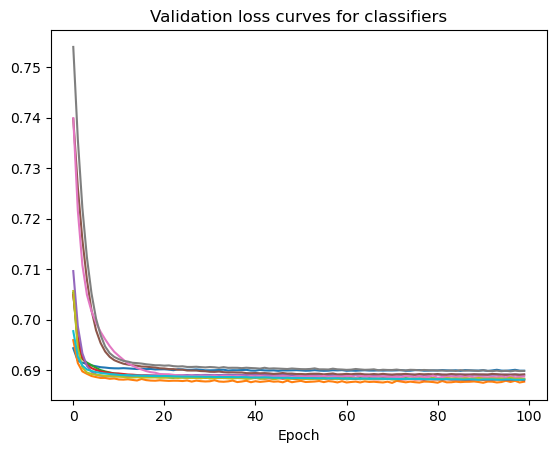

In [28]:
# Check that training looks to have converged
plt.plot(np.array(losses).T)
plt.xlabel("Epoch")
plt.title("Validation loss curves for classifiers")
plt.show()

In [31]:
Z = (np.array(classifier_scores) - 0.5) * 2 * np.sqrt(10_000) # N(0,1) values under null hypothesis
ps = 2*(1 - norm.cdf(np.abs(Z))) # p-values under null hypothesis
print(f"Classifier score avg: {np.array(classifier_scores).mean()}")
print(f"Z-score avg: {Z.mean()}")
print(f"p-value avg: {ps.mean()}")

Classifier score avg: 0.501121406
Z-score avg: 0.2242812000000005
p-value avg: 0.8257707834407931
